###### Imaging Methods in Granular & Complex Fluids
# Day 6: Photoelastimetry

Karen Daniels, Distinguished Professor of Physics, NC State University kdaniel@ncsu.edu

Visiting Fulbright-Nehru Scholar, IISc Civil Engineering, September 2023 to January 2024

## Learning objectives

* explain how photoelasticity arises from elasticity and optics, related via the stress-optic coefficient
* for a known set of vector contact forces on a disk, graph an image of what the photoelastic fringe pattern would be
* start solving the inverse problem (by hand) for your own photoelastic image of a disk
* discuss tips and techniques for utilizing these methods in a laboratory context


# Pre-class

* *Note:* last week's class provides important background for this week's class: please go through those materials if Diwali kept you away for the week. We’ll get you caught up on the laboratory portions this week as we review that material in a new context.
* *Pre-class reading:* https://photoelasticity.net/inverse-analysis/ (and any other sections that look interesting)
* *Bring:* your photoelastic images from last week
* *Do ahead:* add a slide to this [Slide Deck of Introductions](https://docs.google.com/presentation/d/1j8fY-xa7uvxdcrnxsnfIqLDQw1hgo5-AknLChOpNZYg/edit#slide=id.p) + add `opencv` to your python installation
* Access to files in Day 6 Folder (download .zip file to your computer)


# In-Class

 

## Photoelasticity 

The single-particle-sized polariscopes we made last week can be scaled up to work in a laboratory context, up to thousands of grain (given good enough image-resolution). Here's an example:

![image of a few dozen photoelastic particles under loading, and reconstructed image of the same](https://photoelasticity.net/uploads/7e9d15a3fc844774cb987ea3fb530f0e/Force_measurement.svg "Source: photoelasticity.net")

The image on the left is taken through a darkfield polarisope with circular polarizers/analyzers. The image on the right is a *pseudo-image* created from a list of all contact centers, all contact points between grains, and the vector force at each of those contact points. How is this done?

## Stress-induced birefringence

Most polymers have the proporty that their index of refraction (at any point in the material) is modified in the presence of stresses. In many case, the relationship between components of stress tensor ${\bf sigma}$ and refractive index $n$ is linear, such that difference between these values between along the two eigenvalues $(1,2)$ of the stress tensor is given by

$$ n_1 - n_2 = C (\sigma_1 - \sigma_2).$$

The quantity $C$ is a material property of the medium, and is given the name *stress-optic coefficient*. They key optics result we'll rely on is that the relative phase shift of wave components along these two directions can be calculated from 

$$\theta = \frac{2 \pi C h}{\lambda} (\sigma_1 - \sigma_2)$$

where the path length of the light through the medium is $h$ and the wavelength of the light is $\lambda$.  Also, this factor of $1/\lambda$ is the key reason we want to use monochromatic light in our experiments (or else use a single color-channel of our camera), but in reality $C = C(\lambda)$ as well.

The intensity $I$ of light is given by the sqaure of the magnitude of the the transmitted light wave $sin(\frac{\theta}{2})$, so that 

$$ I \propto \sin^2 \left[ \frac{\pi}{F_\sigma} (\sigma_1 - \sigma_2) \right] $$

and we've collected the values $F_\sigma = \frac{C h}{\lambda}$ into a single number which is typically constant for a given experiment (same particles, same lighting). 

Note that because inverting the $\sin^2$ function is not single-valued, we can take a known stress difference and directly calculate changes in the transmitted light intensity, but the inverse problem does not have an anlytical solution. Therefore, we will first demonstrate the forward problem, and then talk about methods for solving the inverse problem (which is what is needed in a laboratory context).

## Stress field on a loaded disk

Classical elasticity theory provides a solutions for point loads along the boundary of a disk of diameter $d$. We will assume the following in writing this analytically: (1) torque and force balance; (2) linear elasticity; (3) plane strain; (4) compatibility: no gaps/overlaps;  (5) no body-force.


Under these assumptions, the solution for $N$ point forces on a disk  is 
$$ \sigma_{rr} = - \sum_{i=1}^N \frac{2 f_i}{\pi R}\frac{\cos \theta_i}{r_i}+\sum_{i=1}^N \frac{f_i}{\pi R}\cos\alpha_i $$
where the coordinate system is given in this schematic. Vector ${\vec r}_i$ (magnitude $r_i$) is the location of each contact and ${\vec f}_i$ (magnitude $f_i$) is the force on that contact, with $\theta_i$ the angle between these two vectors. All  other components of $\sigma$ are zero. (see Daniels et al. 2017 for a derivation). 

![disc with coordinate system](fig9-srressDisc.png "Source: Daniels et al.  2017")


## Graphing the transmitted light

To plot an image of the transmitted light there requires two steps: (1) write a grid of pixels across the disk, apply the contact forces, and calculate $\sigma_1 - \sigma_2$ at each pixel; (2) calculate the relative intensity from the stress-optic equation. 

To do this you will need to know the stress-optic coefficient for your material. The particles we used last week were made from ClearFlex 50, which we have previously measured to have a $C \approx 2500$ Brewsters (1 Br = $10^{12}$~m$^2$/N).

To perform this calculation, we will use some code written by Jack Featherstone, released on [GitHub](https://github.com/Jfeatherstone/pepe) as the Python package PePe: https://jfeatherstone.xyz/pepe/pepe/. So that we can perform these calculation in a single notebook, I have copied the functions we need into the file `pepe-excerpts.py`, and we'll run them in the cell below. 

In [1]:
import numpy as np              # for scientific calculations
import matplotlib.pyplot as plt # for plotting
import skimage                  # for image-processing
import imageio                  # for reading/writing images
from skimage.util import img_as_ubyte
from matplotlib.patches import Circle

#!python pepe-excerpts.py
%run pepe-excerpts.py

This next cell sets the parameters for your image. For the moment, I am using some default values to get you started, but they're not unreasonable. You can play with all of these parameters to see what they do, for instance:
* making more/fewer contacts
* reducing the size of the particle
* changing the spacing of contact
* adding some tangential force
* setting `brightfield=True`
* changing $F_\sigma$

Also to think about:
* what effect will camera resolution have on interpretation of such pictures?
* why do we want to use monochromatic light?

In [2]:
pxPerMeter = 10000.
imageShape = (500,500)
center = np.array([imageShape[0]/2, imageShape[1]/2], dtype=np.int64)
radius = 200.
numForces = 3
fSigma = 100.
brightfield = False

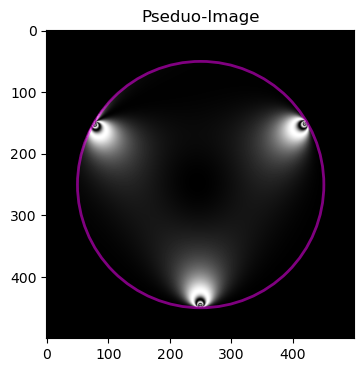

In [3]:
# these use the same coordinate system described above.
forces = np.zeros(numForces) + .2  # in Newtons
alphas = np.zeros(numForces)  #alpha = 0 means no tangential force
betas = 2*np.pi*np.arange(numForces)/numForces # 2pi/N = equall-spaced contacts 

alphas[2] = 0.5 #give one of the contact forces a non-normal direction

pseudoimage = genSyntheticResponse(forces, alphas, betas, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape, center=center)

f, (ax0) = plt.subplots(1,1, figsize=(4,4))
ax0.imshow(pseudoimage, cmap = 'gray')
circle = Circle(center, radius, edgecolor='magenta', facecolor="none", linewidth=2, alpha=0.5)
ax0.add_patch(circle) 
ax0.set_title('Pseduo-Image')
plt.show()

## Try to find a set of forces that fit your own image

Next, change the code below to be approximately correct for the images you took last week (or the one I put here). Keep fiddling with the values until you get one that's at least sort of reasonable. What forces did you find? Is there any tangential force detectable, from friction?

In [4]:
pxPerMeter = 10000.
imageShape = (500,500)
center = np.array([imageShape[0]/2, imageShape[1]/2], dtype=np.int64)
radius = 200.
numForces = 3
#h = 
#C = 
#lambda = 
fSigma = 100.  # = do a calculation here instead, based on the numbers above
brightfield = False

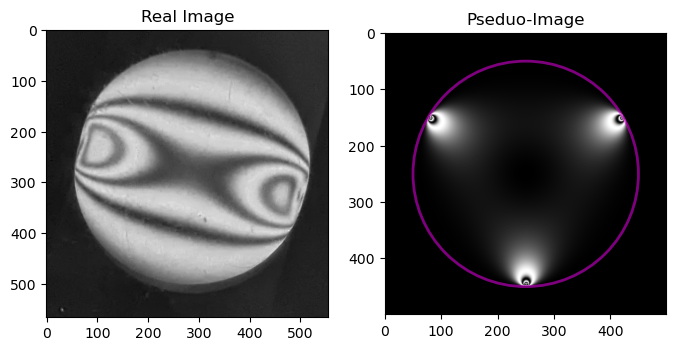

In [5]:
forces = np.zeros(numForces) + .2
alphas = np.zeros(numForces)
betas = 2*np.pi*np.arange(numForces)/numForces

myimage = skimage.io.imread('Amitesh-fringes.jpg')
myimage = img_as_ubyte(myimage[:,:,1])  #gets the green channel only

pseudoimage = genSyntheticResponse(forces, alphas, betas, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape, center=center)

f, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))
ax0.imshow(myimage, cmap='gray')
ax0.set_title('Real Image')
ax1.imshow(pseudoimage, cmap = 'gray')
circle = Circle(center, radius, edgecolor='magenta', facecolor="none", linewidth=2, alpha=0.5)
ax1.add_patch(circle) 
ax1.set_title('Pseduo-Image')
plt.show()

## Measuring the stress-optic coefficient
 
Above, we worked with a known value for $C$, the stress-optic coefficient. In practice, you would need to measure this for a new material. This can be done by using a simple loading geometry: two point contacts that are directly positioned directly opposite each other. In this geometry, the stress tensor at the center of the disk is given analytically by:

\begin{eqnarray}
 \sigma_{xx} & =  &\frac{2f}{2\pi R} \\ 
 \sigma_{yy} & = &- \frac{6f}{2\pi R} \\
 \sigma_{xy} & = &  0
\end{eqnarray}
h
This gives $\sigma_{yy} = -3\sigma_{xx}$, and the principal stress (difference in the eigenvalues)  is $\sigma_1-\sigma_2 = | \sigma_{xx} - \sigma_{yy} |$. 

In this state, the number fringes is given by
$$ \frac{\lambda}{hC} = \frac{\sigma_1 - \sigma_2}{N_\mathrm{fr}} = \frac{4 f}{\pi R N_\mathrm{fr}} $$

Here is an example of how to count the number of fringes across the disk, from which you can plot a calibration of $C$ if you know the force applied to the disk.


![alt text](fig8.png "Source: Daniels et al. (2017)")

## Automating this process

In order to use this technique in an experiment, the technique typically needs two images: one in which the particles are clearly visible, for centroid-finding, and another in which the fringes are clearly visible. Often, this is done by illuminating the system in red, unpolarized light (centroids) and green, polarized light (photoelasticity) and using the red and green channels on the camera to create the two images. 

From this point, a typical data analysis pathway proceeds as follows:
* locate all particles and determine their radii from an image in unpolarized light 
* using the distances between the centers of the particles and their neighbors, identify likely contact points
* estimate the force at each contact using the $G^2$ method
* for each particle, use these contacts and forces as an initial guess, and run an optimizer (e.g Levenberg-Marquart) which adjusts the contact forces until a minimum value for the difference between the image and the pseudo-image is obtained
* the resulting forces can be contrained to be force-balanced on the particle (or not), depending on whether that's a reasonable choice

Note that when the optimum solutions there is no guarantee of reciproal (equal and opposite) forces for the two sides of a contact, or that the optimum found is the best possible solution, or that the contact list was correct.

Post-processing can tweak the final list of contacts and forces to do things like:
* switch to having reciprocity on the contacts (by averaging the two forces) instead of force and torque balance at the particle scale
* fix bad fits by substituting data from their neighbors
* adding/subtracting missing/extra contacts
* etc.


# Post-class

## Every week

If you and your group worked together on a single notebook, don't forget to email each other a copy of the final version.

Please feel free to complete any parts you didn't finish, and ask questions at the start of the next class.

## Additional resources

Join this [Zotero Library](https://www.zotero.org/groups/5274108/granularimaging) in order to get access to all course readings (PDFs and web pages) in one place without needing library access.

* Ramesh, K. (2021) Developments in Photoelasticity: A renaissance. IOP Publishing. https://iopscience.iop.org/book/978-0-7503-2472-4 
* Abed Zadeh, Aghil, Jonathan Bares, Theodore A. Brzinski, Karen E. Daniels, Joshua Dijksman, Nicolas Docquier, Henry O. Everitt. (2019) “Enlightening Force Chains: A Review of Photoelasticimetry in Granular Matter.” Granular Matter 21 (4): 83. https://doi.org/10.1007/s10035-019-0942-2.
* Daniels, Karen E., Jonathan E. Kollmer, and James G. Puckett. (2017) “Photoelastic Force Measurements in Granular Materials.” Review of Scientific Instruments 88 (5): 051808. https://doi.org/10.1063/1.4983049.

### Open science expertise

The community of photoelastic-users has created a shared resource https://photoelasticity.net which a platform learning more.

![logo for photoelasticity.net](LogoPhotoelasticity_v7.png)

Three open-source packages to automate the inversion process:
* https://github.com/jekollmer/PEGS (Matlab)
* https://git.immc.ucl.ac.be/olantsoght/pegs_py (Python)
* https://github.com/Jfeatherstone/pepe (Python)
